In [60]:
%matplotlib inline
from time import sleep
import numpy as np 
import scipy
import os
import sys
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix

from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.optimizers import RMSprop

from keras.layers.core import Dense, Dropout, Activation, Flatten


#Questions:
#question: Is there a better way to do the input than just flattening?


#Completed tasks
#Write a normal neural net to try to predict the next measurement with the window method in multiple dimensions (train_baseline_multi)
#Write a deep neural net to try to predict the next measurement with the window method in multiple dimensions (train_baseline_multi)
#Write a Random Forest Regressor to try to predict the next measurement with the window method in multiple dimensions (train_forest)
#Consolidate the pipeline - shape data / create models / validate models 
#Sliding window with a RNN to predict the next value (train_window_regression_rnn)
#Random Forest Classifier to classify FLAG at the next measurement(30 trees, 30 features)
#Neural Network Classifier (1 layer, 512 nodes) 
#Deep Neural Network Classifier (2 layers, 512 nodes) 
#Recurrent Neural Network for classification using window
#Complete all the quizzes and submit a request for MIMIC
#Sanity check for A = B
    #If it doesn't work, make sure the rolling/unrolling is correct
    #Switch order of patient and timestep
    #If it still doesn't work, try only feeding it one previous instead of 20 previous
#Completed today
#Fix the regression
    #Make it so that the matrix predictor gives 0 error
    #Make the other regressors make sense
    #Make all the regressions work
#Make all the classifications work similarly

#--------------------------------------------------------------------------------------------------------------------------------------------
#Writeup: Regression where A \neq B
#Writeup: Regression where A = B
#Writeup: Classification 
#--------------------------------------------------------------------------------------------------------------------------------------------
#TODO 

#Sequence to sequence rnn classification
    #Get a 1-d version working DONE
    #Investigate what happens more closely by reducing the number of people to 2
    #Get a multiple dimension version working
#Investigate if any of our methods can actually predict in the time period where the flag is being flipped: e.g. the previous window has both 0 and 1
#Write a normal neural net to take prediction from rnn and predict 1/0
#Investigate this idea of deleting data
#Add a stateful try where the rnn is an autoencoder ( http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) and then another LSTM

In [61]:
# fix random seed for reproducibility
np.random.seed(7)
V=np.random.randn(10)
print(V.dot(V), np.linalg.norm(V)**2)

8.33980975239 8.33980975239


In [62]:
#Setup for the generation of the data 
d=10 ##number of measurements per patient per time unit
k=2 ##complexity of the time series
n=200 ## number of patients

len_sequence = 10
epochs = 25

T=175 ## amount of time measured for each patient (also batch size)
sigmaw=0.2##randomness
#d by d
U=np.random.randn(d,k).dot(np.random.randn(k,d))
betashift=np.random.randn(d)/np.sqrt(d)  ## used to check when we switch to the other time series
#normalized U
A=0.9*U/np.linalg.norm(U,ord=2)
#V is also d by d
V=np.random.randn(d,k).dot(np.random.randn(k,d))
#normalized V
B = .9*V/np.linalg.norm(V,ord=2) 
#B = A #Set B = A for sanity checking
X = np.zeros((n,T,d)) #this represents n patients, in d-dimensions, for T time-steps

flags = np.zeros(X.shape)
flag = 1

In [63]:
#Generate the data, fill in X, Y, flags
for j in range(n): #for each patient
    X[j,0,:]=np.random.randn(d)/np.sqrt(d)
    flag=1
    flag_switch = -1
    for i in range(1,T): #for each time      
        if flag and ((X[j,i-1,:].dot(betashift))>.5): ##if flag was true and we go above a certain threshold, then set flag=0
            flag = 0
            flag_switch = i
        ## we can think of flag has flag==1 means not critical, flag==0 means critical
        if flag:
            X[j,i,:]=A.dot(X[j,i-1,:])+sigmaw*np.random.randn(d)
        else:
            X[j,i,:]=B.dot(X[j,i-1,:])+sigmaw*np.random.randn(d)
    for i in range(0, T - len_sequence): #for each time
        if flag_switch >= 0: #if the flag ever switched
            flags[j, i, :] = (flag_switch <= i + len_sequence) * np.ones(flags[j,i,:].shape) #set flags            
## X is a n by d by T tensor
## Y is just X but shifted one backwards
## n represents independent trials (think of them as patients or time periods for patients separated)
## T represents the time horizon (how long we observe a patient, for now T is the same for everybody, but we can imagine that changing)
## d is the number of measurements that we have per patient per time.
## flags are num_patients * num_timesteps * dimensionality

In [64]:
#Format the data with a window of length len_sequence

crazy = np.array([X[:, i: i + len_sequence] for i in range(X.shape[1] - len_sequence)])
crazy_y = np.array([X[:, i + len_sequence] for i in range(X.shape[1] - len_sequence)])
crazy_flags = np.array([flags[:, i] for i in range(X.shape[1] - len_sequence)])
oned_flags = np.array([flags[:, i, 0:1] for i in range(X.shape[1] - len_sequence)])

print(crazy.shape)
print(crazy_y.shape)
print(crazy_flags.shape)
print(oned_flags.shape)

(165, 200, 10, 10)
(165, 200, 10)
(165, 200, 10)
(165, 200, 1)


In [65]:
"""
patient_1 = X[0, :, 0]
print("patient 1: \n" + str(patient_1))
crazy_patient_1 = crazy[:,0,:,0]
print("crazy_patient 1: \n" + str(crazy_patient_1))
crazy_patient_1_y = crazy_y[:,0,0]
print("crazy_patient 1 y : \n" + str(crazy_patient_1_y))
print(X_train[0])
"""

'\npatient_1 = X[0, :, 0]\nprint("patient 1: \n" + str(patient_1))\ncrazy_patient_1 = crazy[:,0,:,0]\nprint("crazy_patient 1: \n" + str(crazy_patient_1))\ncrazy_patient_1_y = crazy_y[:,0,0]\nprint("crazy_patient 1 y : \n" + str(crazy_patient_1_y))\nprint(X_train[0])\n'

In [66]:
def prepare_baseline():
    #Reshape data and flatten for baseline models
    rolled_x = crazy[:,:,:,:]
    rolled_y = crazy_y[:,:,:]

    print (rolled_x.shape)
    print (rolled_y.shape)

    unrolled_x = np.zeros((crazy.shape[0]*crazy.shape[1], crazy.shape[2] * crazy.shape[3]))
    unrolled_y = np.zeros((crazy.shape[0] * crazy.shape[1], crazy.shape[3]))

    for i in range(crazy.shape[1]): #patients
        for j in range(crazy.shape[0]): #time steps
            unrolled_y[i * crazy.shape[0] + j] = rolled_y[j,i,:]            
            for l in range(crazy.shape[2]):#len_sequence
                for k in range(crazy.shape[3]): #dimensionality
                    unrolled_x[i * crazy.shape[0] + j][l*crazy.shape[3] + k] = rolled_x[j,i,l,k]

    print (unrolled_x.shape)
    print (unrolled_y.shape)
    transition_point = int(unrolled_x.shape[0] * .8)
    
    X_train = np.array(unrolled_x[:transition_point,:])
    y_train = np.array(unrolled_y[:transition_point])
    X_test = np.array(unrolled_x[transition_point:,:])
    y_test = np.array(unrolled_y[transition_point:])

    print (X_train.shape)
    print (y_train.shape)
    print (X_test.shape)
    print (y_test.shape)
    
    return (X_train, y_train, X_test, y_test)

In [67]:
(X_train, y_train, X_test, y_test) = prepare_baseline()


(165, 200, 10, 10)
(165, 200, 10)
(33000, 100)
(33000, 10)
(26400, 100)
(26400, 10)
(6600, 100)
(6600, 10)


In [68]:
#Given a model that uses the flattened window, this will print its mean squared error and plot it's results versus reality
def analyze(model, X_test, y_test, rnn=False):
    plt.clf()
    results = model.predict(X_test)
    manual = np.zeros(y_test.shape)
    if not rnn:
        for i in range(manual.shape[0]):
            manual[i,:] = A.dot(X_test[i,-d:])
    else:
        for i in range(manual.shape[0]):
            manual[i,:] = A.dot(X_test[i,-1,:])
        
    preds = results[int(manual.shape[0]*.5):(int(manual.shape[0]*.5) + 10),:]
    reals = y_test[int(manual.shape[0]*.5):(int(manual.shape[0]*.5) + 10),:]
    manuals = manual[int(manual.shape[0]*.5):(int(manual.shape[0]*.5) + 10), :]
    
    plt.plot(preds, color='red')
    plt.plot(reals, color='blue')
    plt.plot(manuals, color='yellow')
    
    all_z = np.zeros(y_test.shape)
    
    print("all_zero error: " + str(mean_absolute_error(y_test, all_z)))
    print("smart_predictor error: " + str(mean_absolute_error(y_test, manual)))
    print("Actual Error: " + str(mean_absolute_error(y_test, results)))

In [30]:
#Given a model that uses the flattened window for classification,this will print its confusion matrix and plot it's results versus reality
def analyze_classification(model, X_test, y_test):
    results = model.predict(X_test)
    #only plotting the first 400 because otherwise you can't see anything
    preds = results[:400]
    reals = y_test[:400]
    plt.plot(preds, color='red')
    plt.plot(reals, color='blue')
    print(confusion_matrix(y_test, results))
    #Compare to all zeros
    """
    print("Try all zeros")
    zeros = np.zeros(5600)
    print(confusion_matrix(y_test, zeros))
    """

In [31]:
def train_forest(X_train, y_train):
    ne = [30, 40]
    nf = [30, 40]
    models = []
    for e in ne:
        for f in nf:   
            model = RandomForestRegressor(n_estimators=e, max_features = f, verbose=2)
            model.fit(X_train, y_train)
            models.append(model)
    return models

In [32]:
def train_baseline_nn(X_train, y_train, X_test, y_test):
    #Baseline model in multiple dimensions: predicts the next measurement, all 10 dimensions
    rms = RMSprop()
    model = Sequential()
    model.add(Dense(512, input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mean_squared_error', optimizer=rms)
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))
    return model

In [33]:
def train_baseline_multi_deep(X_train, y_train, X_test, y_test):
    #Baseline model in multiple dimensions: predicts the next measurement, all 10 dimensions
    rms = RMSprop()
    model = Sequential()
    model.add(Dense(512, input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mean_squared_error', optimizer=rms)
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))
    return model

In [34]:
#(X_train, y_train, X_test, y_test) = prepare_baseline()
models = {}
tree_models = train_forest(X_train, y_train)
models['tree'] = tree_models[0]
models['nn'] = train_baseline_nn(X_train, y_train, X_test, y_test)
models['deep_nn'] = train_baseline_multi_deep(X_train, y_train, X_test, y_test)


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   42.0s finished



building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   55.8s finished



building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   57.3s finished



building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.4min finished



Train on 26400 samples, validate on 6600 samples
Epoch 1/10
26400/26400 [==============================] - 3s - loss: 0.0450 - val_loss: 0.0415
Epoch 2/10
26400/26400 [==============================] - 3s - loss: 0.0412 - val_loss: 0.0410
Epoch 3/10
26400/26400 [==============================] - 3s - loss: 0.0403 - val_loss: 0.0410
Epoch 4/10
26400/26400 [==============================] - 3s - loss: 0.0399 - val_loss: 0.0408
Epoch 5/10
26400/26400 [==============================] - 3s - loss: 0.0396 - val_loss: 0.0408
Epoch 6/10
26400/26400 [==============================] - 3s - loss: 0.0394 - val_loss: 0.0408
Epoch 7/10
26400/26400 [==============================] - 3s - loss: 0.0392 - val_loss: 0.0409
Epoch 8/10
26400/26400 [==============================] - 3s - loss: 0.0390 - val_loss: 0.0409
Epoch 9/10
26400/26400 [==============================] - 3s - loss: 0.0388 - val_loss: 0.0410
Epoch 10/10
26400/26400 [==============================] - 3s - loss: 0.0387 - val_loss: 0.0410

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


all_zero error: 0.168840895246
smart_predictor error: 0.159880463551
Actual Error: 0.164463405344
all_zero error: 0.168840895246
smart_predictor error: 0.159880463551
Actual Error: 0.161696706556
all_zero error: 0.168840895246
smart_predictor error: 0.159880463551
Actual Error: 0.160718555103


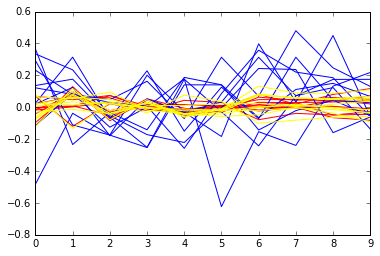

In [35]:
analyze(models['tree'], X_test, y_test)
analyze(models['nn'], X_test, y_test)
analyze(models['deep_nn'], X_test, y_test)

In [36]:
def prepare_rnn():
    #Reshape data and flatten for baseline models
    rolled_x = crazy[:,:,:,:]
    rolled_y = crazy_y[:,:,:]

    print (rolled_x.shape)
    print (rolled_y.shape)

    unrolled_x = np.zeros((crazy.shape[0] * crazy.shape[1], crazy.shape[2], crazy.shape[3]))
    unrolled_y = np.zeros((crazy.shape[0] * crazy.shape[1], crazy.shape[3]))

    #maybe we should switch the order of these (but also maybe not it depends how batching works)
    for i in range(crazy.shape[1]): #patients
        for j in range(crazy.shape[0]): #time steps
            unrolled_x[i * crazy.shape[0] + j] = rolled_x[j,i,:,:]
            unrolled_y[i * crazy.shape[0] + j] = rolled_y[j,i,:]            

    print (unrolled_x.shape)
    print (unrolled_y.shape)

    transition_point = int(unrolled_x.shape[0] * .8)
    
    X_train = np.array(unrolled_x[:transition_point,:])
    y_train = np.array(unrolled_y[:transition_point])
    X_test = np.array(unrolled_x[transition_point:,:])
    y_test = np.array(unrolled_y[transition_point:])
    
    print (X_train.shape)
    print (y_train.shape)
    print (X_test.shape)
    print (y_test.shape)
    
    return (X_train, y_train, X_test, y_test)
    

In [37]:
(X_train, y_train, X_test, y_test) = prepare_rnn()

(165, 200, 10, 10)
(165, 200, 10)
(33000, 10, 10)
(33000, 10)
(26400, 10, 10)
(26400, 10)
(6600, 10, 10)
(6600, 10)


In [38]:
#Predict the next measurement.  Trained using the window method.  A GRU + a Dense layer
def train_window_regression_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(GRU(16,activation='relu', input_dim = d))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(d))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))
    return model

In [39]:
rnn_regressor = train_window_regression_rnn(X_train, y_train, X_test, y_test)

Train on 26400 samples, validate on 6600 samples
Epoch 1/10
26400/26400 [==============================] - 4s - loss: 0.0421 - val_loss: 0.0406
Epoch 2/10
26400/26400 [==============================] - 4s - loss: 0.0406 - val_loss: 0.0403
Epoch 3/10
26400/26400 [==============================] - 4s - loss: 0.0404 - val_loss: 0.0403
Epoch 4/10
26400/26400 [==============================] - 4s - loss: 0.0403 - val_loss: 0.0403
Epoch 5/10
26400/26400 [==============================] - 4s - loss: 0.0403 - val_loss: 0.0403
Epoch 6/10
26400/26400 [==============================] - 4s - loss: 0.0403 - val_loss: 0.0402
Epoch 7/10
26400/26400 [==============================] - 4s - loss: 0.0403 - val_loss: 0.0403
Epoch 8/10
26400/26400 [==============================] - 5s - loss: 0.0403 - val_loss: 0.0403
Epoch 9/10
26400/26400 [==============================] - 5s - loss: 0.0402 - val_loss: 0.0403
Epoch 10/10
26400/26400 [==============================] - 4s - loss: 0.0403 - val_loss: 0.0402


In [40]:
X_test[0,-1,:].shape


(10,)

all_zero error: 0.168840895246
smart_predictor error: 0.159880463551
Actual Error: 0.160057111654


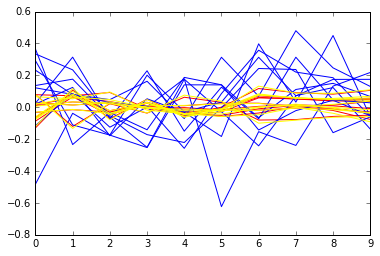

In [41]:
analyze(rnn_regressor, X_test, y_test, rnn=True)

In [69]:
def prepare_classification_rnn():
    #Reshape data and flatten for baseline models
    rolled_x = crazy[:,:,:,:]
    rolled_y = oned_flags[:,:,:]

    print (rolled_x.shape)
    print (rolled_y.shape)

    unrolled_x = np.zeros((crazy.shape[0] * crazy.shape[1], crazy.shape[2], crazy.shape[3]))
    unrolled_y = np.zeros((crazy.shape[0] * crazy.shape[1]))

    #maybe we should switch the order of these (but also maybe not it depends how batching works)
    for i in range(crazy.shape[1]): #time steps
        for j in range(crazy.shape[0]): #patients
            unrolled_x[i * crazy.shape[0] + j] = rolled_x[j,i,:,:]
            unrolled_y[i * crazy.shape[0] + j] = rolled_y[j,i,:]            

    print (unrolled_x.shape)
    print (unrolled_y.shape)
    transition_point = int(unrolled_x.shape[0] * .8)
    
    X_train = np.array(unrolled_x[:transition_point,:])
    y_train = np.array(unrolled_y[:transition_point])
    X_test = np.array(unrolled_x[transition_point:,:])
    y_test = np.array(unrolled_y[transition_point:])

    print (X_train.shape)
    print (y_train.shape)
    print (X_test.shape)
    print (y_test.shape)
    
    return (X_train, y_train, X_test, y_test)


In [70]:
def prepare_classification_baseline():
    #Reshape data and flatten for baseline models
    rolled_x = crazy[:,:,:,:]
    rolled_y = oned_flags[:,:,:]

    print (rolled_x.shape)
    print (rolled_y.shape)
    unrolled_x = np.zeros((crazy.shape[0]*crazy.shape[1], crazy.shape[2] * crazy.shape[3]))
    unrolled_y = np.zeros((crazy.shape[0] * crazy.shape[1]))

    for i in range(crazy.shape[1]): #patients
        for j in range(crazy.shape[0]): #time steps
            unrolled_y[i * crazy.shape[0] + j] = rolled_y[j,i,:]
            for l in range(crazy.shape[2]):#len_sequence
                for k in range(crazy.shape[3]): #dimensionality
                    unrolled_x[i * crazy.shape[0] + j][l*crazy.shape[3] + k] = rolled_x[j,i,l,k]

    print (unrolled_x.shape)
    print (unrolled_y.shape)
    transition_point = int(unrolled_x.shape[0] * .8)
    
    X_train = np.array(unrolled_x[:transition_point,:])
    y_train = np.array(unrolled_y[:transition_point])
    X_test = np.array(unrolled_x[transition_point:,:])
    y_test = np.array(unrolled_y[transition_point:])
    
    print (X_train.shape)
    print (y_train.shape)
    print (X_test.shape)
    print (y_test.shape)
    
    return (X_train, y_train, X_test, y_test)

In [71]:
def train_classification_forest(X_train, y_train):
    ne = [30]
    nf = [30]
    models = []
    for e in ne:
        for f in nf:   
            model = RandomForestClassifier(n_estimators=e, max_features = f, verbose=2)
            model.fit(X_train, y_train)
            models.append(model)
    return models

In [72]:
(X_train, y_train, X_test, y_test) = prepare_classification_baseline()

(165, 200, 10, 10)
(165, 200, 1)
(33000, 100)
(33000,)
(26400, 100)
(26400,)
(6600, 100)
(6600,)


In [73]:
models = train_classification_forest(X_train, y_train)

building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.0min finished


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


num_estimators: 30
Max Features: 30
[[5104   28]
 [1271  197]]


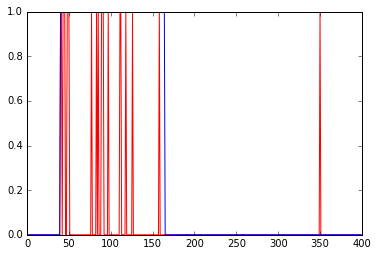

In [74]:
for m in models: 
    print ("num_estimators: " + str(m.n_estimators))
    print ("Max Features: " + str(m.max_features))
    analyze_classification(m, X_test, y_test)

In [75]:
def train_window_classification_nn(X_train, y_train, X_test, y_test):
    #Baseline model in multiple dimensions: predicts the next measurement, all 10 dimensions
    rms = RMSprop()
    model = Sequential()
    model.add(Dense(512, input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))    
    return model

In [76]:
model = train_window_classification_nn(X_train, y_train, X_test, y_test)

Train on 26400 samples, validate on 6600 samples
Epoch 1/10
26400/26400 [==============================] - 2s - loss: 0.4441 - acc: 0.7945 - val_loss: 0.2664 - val_acc: 0.9118
Epoch 2/10
26400/26400 [==============================] - 2s - loss: 0.2312 - acc: 0.9198 - val_loss: 0.1914 - val_acc: 0.9392
Epoch 3/10
26400/26400 [==============================] - 2s - loss: 0.1732 - acc: 0.9417 - val_loss: 0.1630 - val_acc: 0.9474
Epoch 4/10
26400/26400 [==============================] - 2s - loss: 0.1446 - acc: 0.9542 - val_loss: 0.1502 - val_acc: 0.9498
Epoch 5/10
26400/26400 [==============================] - 3s - loss: 0.1237 - acc: 0.9614 - val_loss: 0.1445 - val_acc: 0.9506
Epoch 6/10
26400/26400 [==============================] - 3s - loss: 0.1104 - acc: 0.9662 - val_loss: 0.1421 - val_acc: 0.9527
Epoch 7/10
26400/26400 [==============================] - 2s - loss: 0.0980 - acc: 0.9697 - val_loss: 0.1414 - val_acc: 0.9520
Epoch 8/10
26400/26400 [==============================] - 2s -

[0 0 0 ..., 0 0 0]
[[5009  123]
 [ 196 1272]]


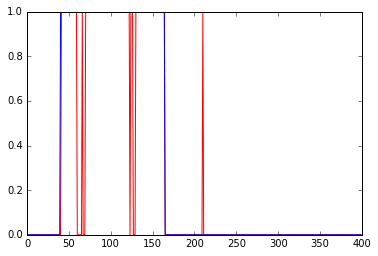

In [77]:
results = model.predict(X_test)[:,0]
results = np.where(results>.5, 1, 0)
print (results)
#only plotting the first 400 because otherwise you can't see anything
preds = results[:400]
reals = y_test[:400]

plt.plot(preds, color='red')
plt.plot(reals, color='blue')
print(confusion_matrix(y_test, results))
#Compare to all zeros

In [78]:
def train_window_classification_deep_nn(X_train, y_train, X_test, y_test):
    #Baseline model in multiple dimensions: predicts the next measurement, all 10 dimensions
    rms = RMSprop()
    model = Sequential()
    model.add(Dense(512, input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))    
    return model

In [79]:
model2 = train_window_classification_deep_nn(X_train, y_train, X_test, y_test)

Train on 26400 samples, validate on 6600 samples
Epoch 1/10
26400/26400 [==============================] - 7s - loss: 0.3631 - acc: 0.8408 - val_loss: 0.1888 - val_acc: 0.9355
Epoch 2/10
26400/26400 [==============================] - 7s - loss: 0.1800 - acc: 0.9332 - val_loss: 0.1585 - val_acc: 0.9445
Epoch 3/10
26400/26400 [==============================] - 7s - loss: 0.1376 - acc: 0.9508 - val_loss: 0.1477 - val_acc: 0.9514
Epoch 4/10
26400/26400 [==============================] - 7s - loss: 0.1103 - acc: 0.9620 - val_loss: 0.1552 - val_acc: 0.9495
Epoch 5/10
26400/26400 [==============================] - 8s - loss: 0.0929 - acc: 0.9672 - val_loss: 0.1584 - val_acc: 0.9505
Epoch 6/10
26400/26400 [==============================] - 8s - loss: 0.0810 - acc: 0.9724 - val_loss: 0.1558 - val_acc: 0.9518
Epoch 7/10
26400/26400 [==============================] - 8s - loss: 0.0688 - acc: 0.9756 - val_loss: 0.1666 - val_acc: 0.9474
Epoch 8/10
26400/26400 [==============================] - 8s -

[0 0 0 ..., 0 0 0]
[[5011  121]
 [ 212 1256]]


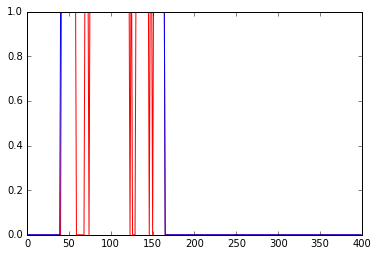

In [80]:
results = model2.predict(X_test)[:,0]
results = np.where(results>.5, 1, 0)
print (results)
#only plotting the first 400 because otherwise you can't see anything
preds = results[:400]
reals = y_test[:400]

plt.plot(preds, color='red')
plt.plot(reals, color='blue')
print(confusion_matrix(y_test, results))
#Compare to all zeros

In [81]:
#Predict the next measurement.  Trained using the window method.  A GRU + a Dense layer
def train_window_classification_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(GRU(16,activation='relu', input_dim = d))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))
    return model

In [82]:
(X_train, y_train, X_test, y_test) = prepare_classification_rnn()

(165, 200, 10, 10)
(165, 200, 1)
(33000, 10, 10)
(33000,)
(26400, 10, 10)
(26400,)
(6600, 10, 10)
(6600,)


In [83]:
model = train_window_classification_rnn(X_train, y_train, X_test, y_test)

Train on 26400 samples, validate on 6600 samples
Epoch 1/10
26400/26400 [==============================] - 4s - loss: 0.5525 - acc: 0.7312 - val_loss: 0.4115 - val_acc: 0.8152
Epoch 2/10
26400/26400 [==============================] - 4s - loss: 0.3411 - acc: 0.8596 - val_loss: 0.2412 - val_acc: 0.9073
Epoch 3/10
26400/26400 [==============================] - 4s - loss: 0.2062 - acc: 0.9237 - val_loss: 0.1896 - val_acc: 0.9324
Epoch 4/10
26400/26400 [==============================] - 4s - loss: 0.1607 - acc: 0.9433 - val_loss: 0.1632 - val_acc: 0.9423
Epoch 5/10
26400/26400 [==============================] - 4s - loss: 0.1352 - acc: 0.9518 - val_loss: 0.1484 - val_acc: 0.9465
Epoch 6/10
26400/26400 [==============================] - 4s - loss: 0.1217 - acc: 0.9584 - val_loss: 0.1521 - val_acc: 0.9450
Epoch 7/10
26400/26400 [==============================] - 4s - loss: 0.1135 - acc: 0.9602 - val_loss: 0.1423 - val_acc: 0.9502
Epoch 8/10
26400/26400 [==============================] - 4s -

[0 0 0 ..., 0 0 0]
[[4965  167]
 [ 148 1320]]


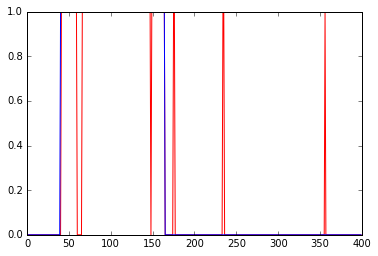

In [84]:
results = model.predict(X_test)[:,0]
results = np.where(results>.5, 1, 0)
print (results)
#only plotting the first 400 because otherwise you can't see anything
preds = results[:400]
reals = y_test[:400]

plt.plot(preds, color='red')
plt.plot(reals, color='blue')
print(confusion_matrix(y_test, results))
#Compare to all zeros

In [ ]:
#EVERYTHING BELOW HERE IS NOT WORKING / OLD CODE

In [ ]:
#given train_split, train the model using the first train_split examples
#which = 0 for the normal prediction
#which = 1 for crazy_flags
#which = 2 for oned_flags
def train_stage1(train_split, which):
    #First model: Using the sliding window
    hists = []
    model = Sequential()
    model.add(GRU(128,activation='relu', input_shape=(crazy.shape[2:])))
    if which == 2:
        model.add(Dense(1))
    else:
        model.add(Dense(d))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(train_split): # for each patient
        this_patient_x = crazy[:,i,:,:]
        if which == 0:
            this_patient_y = crazy_y[:,i,:]
        elif which == 1:
            this_patient_y = crazy_flags[:,i,:]
        else:
            this_patient_y = oned_flags[:,i,0:1]
        for ii in range(crazy.shape[0]): #for each window of time sequence
            this_patient_x_i = np.array([this_patient_x[ii,:,:]])
            if which == 2:
                this_patient_y_i = np.array([this_patient_y[ii,0:1]])
            else:
                this_patient_y_i = np.array([this_patient_y[ii,:]])
            hists.append(model.train_on_batch(this_patient_x_i, this_patient_y_i))
        model.reset_states()
    return hists, model

In [ ]:
def train_stage2(train_split):
    #second model: trading a stateful rnn using this batch thing
    hists = []
    model = Sequential()
    
    X  # this is our input data, of shape (32, 21, 16)
    # we will feed it to our model in sequences of length 10

    model = Sequential()
    model.add(LSTM(32, batch_input_shape=(32, 10, 16), stateful=True))
    model.add(Dense(16, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

    # we train the network to predict the 11th timestep given the first 10:
    model.train_on_batch(X[:, :10, :], np.reshape(X[:, 10, :], (32, 16)))

    # the state of the network has changed. We can feed the follow-up sequences:
    model.train_on_batch(X[:, 10:20, :], np.reshape(X[:, 20, :], (32, 16)))

    # let's reset the states of the LSTM layer:
    model.reset_states()

    # another way to do it in this case:
    model.layers[0].reset_states()
    
    model.add(GRU(128,activation='relu', input_shape=(crazy.shape[2:])))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(train_split): # for each patient
        this_patient_x = crazy[:,i,:,:]
        if which == 0:
            this_patient_y = crazy_y[:,i,:]
        elif which == 1:
            this_patient_y = crazy_flags[:,i,:]
        else:
            this_patient_y = oned_flags[:,i,0:1]
        for ii in range(crazy.shape[0]): #for each window of time sequence
            this_patient_x_i = np.array([this_patient_x[ii,:,:]])
            if which == 2:
                this_patient_y_i = np.array([this_patient_y[ii,0:1]])
            else:
                this_patient_y_i = np.array([this_patient_y[ii,:]])
            hists.append(model.train_on_batch(this_patient_x_i, this_patient_y_i))
        model.reset_states()
    return hists, model

In [ ]:
oned_flags.shape
(hists, model) = train_stage1(10, 2)

In [ ]:
#compare the y between them
print(oned_flags[:, 0, 0:1].shape)
#this is y for normal stuff
print(crazy_y[:,i,:][0,:].shape)
#this is y for the newest one
print((oned_flags[:,0,0:1][0,0:1]).shape)
#compare the x between them


In [ ]:
print(crazy[:, patient_num, :, :].shape)
print((crazy[:,0,:,:][0,:,:]).shape)

crazy[:,patient_num,:,:]

In [ ]:
#evaluate the model on the last 10 samples
#which = 0 for the normal prediction
#which = 1 for crazy_flags
#which = 2 for oned_flags
def evaluate(model, which):
    evaluations = []
    for i in range(n-10, n): # for each patient not in the training
        this_patient_x = crazy[:,i,:,:]
        if which == 0:
            this_patient_y = crazy_y[:,i,:]
        elif which == 1:
            this_patient_y = crazy_flags[:,i,:]
        else:
            this_patient_y = oned_flags[:,i,:]
        for ii in range(crazy.shape[0]): #for each window of time sequence
            this_patient_x_i = np.array([this_patient_x[ii,:,:]])            
            this_patient_y_i = np.array([this_patient_y[ii,:]])
            evaluations.append(model.evaluate(this_patient_x_i, this_patient_y_i, verbose=0))
        model.reset_states()
    return evaluations

In [ ]:
histories = {}
all_evals = {}
which = 2
for training_amount in range(10, 100, 10):
    #Train the model
    (hists, model) = train_stage1(training_amount, which)

    #Check training results of the data
    hist_values = []
    for hist in hists:
        hist_values.append(hist.item())
    #plt.plot(hist_values)
    histories[training_amount] = (sum(hist_values)/float(len(hist_values)))

    #Check evaluation of the model
    evaluations = evaluate(model, which)
    #plt.plot(evaluations)
    all_evals[training_amount] = (sum(evaluations)/float(len(evaluations)))

In [ ]:
print(histories)
for key in histories:
    print (key)
    print (histories[key] - all_evals[key])
print(all_evals)

In [ ]:
#Visually check the prediction of the first reading versus what's actually happening
#(178, 200, 20, 10)

#choose a patient
patient_num = randint(101,199)
#choose a measuremen
measurement = 0

#Get what we are aiming for
if which == 0:
    reality = crazy_y[:, patient_num, measurement]
elif which == 1:
    reality = crazy_flags[:, patient_num, measurement]
elif which == 2:
    reality = oned_flags[:, patient_num, 0:1]
#Get the predictions
model.reset_states()
predictions = model.predict(crazy[:,patient_num,:,:])

#Plot prediction versus reality
plt.plot(predictions[:,0], color='red')
plt.plot(reality, color='blue')

In [ ]:
#Compute MSE
dif = reality - predictions[:,0]
dif = dif ** 2
print ("MSE:")
print (sum(dif)/178)

#Plot the difference
plt.plot(dif)